# Импортируем необходимые библиотеки для реализации Bilateral Filter

In [1]:
import time
import cv2
import numpy as np
import pandas as pd
import pycuda.autoinit
import pycuda.driver
import warnings
from pycuda.compiler import SourceModule
from google.colab.patches import cv2_imshow
warnings.filterwarnings("ignore")

# Реализуем функцию на GPU

In [2]:
BilateralGPU = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;
__global__ void BilateralGPU(unsigned int* result, const int M, const int N, const float sigma_d, const float sigma_r){   
    const int i = threadIdx.x + blockDim.x * blockIdx.x;
    const int j = threadIdx.y + blockDim.y * blockIdx.y;
    if ((i < M) && (j < N)){
            float s = 0;
            float c = 0;
            for (int l = i - 1; l <= i + 1; l++){
                for (int k = j - 1; k <= j + 1; k++){
                    float img1 = tex2D(tex, k, l) / 255;
                    float img2 = tex2D(tex, i, j) / 255;
                    float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                    float r = exp(-pow((img1 - img2) * 255, 2) / pow(sigma_r, 2));
                    c += g * r;
                    s += g * r * tex2D(tex, k, l);
                }
            }
            result[i * N + j] = s / c;
        }
}
""")

# Реализуем функцию на CPU

In [3]:
def BilateralCPU(image, sigma_r, sigma_d):
    result = np.zeros((image.shape[0], image.shape[1]))
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            c, s = 0, 0
            for x in range(i-1, i+2):
                for y in range(j-1, j+2):
                    g = np.exp(-((x - i) ** 2 + (y - j) ** 2) / sigma_d ** 2)
                    r = np.exp(-(image[x, y] - image[i, j]) ** 2 / sigma_r ** 2)
                    c += g*r 
                    s += g*r*image[x, y]
            result[i, j] = s / c
    return result

In [4]:
image_url = '/bilateral_images/test_img.png'
sigma_r = 1000
sigma_d = 5
image = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)

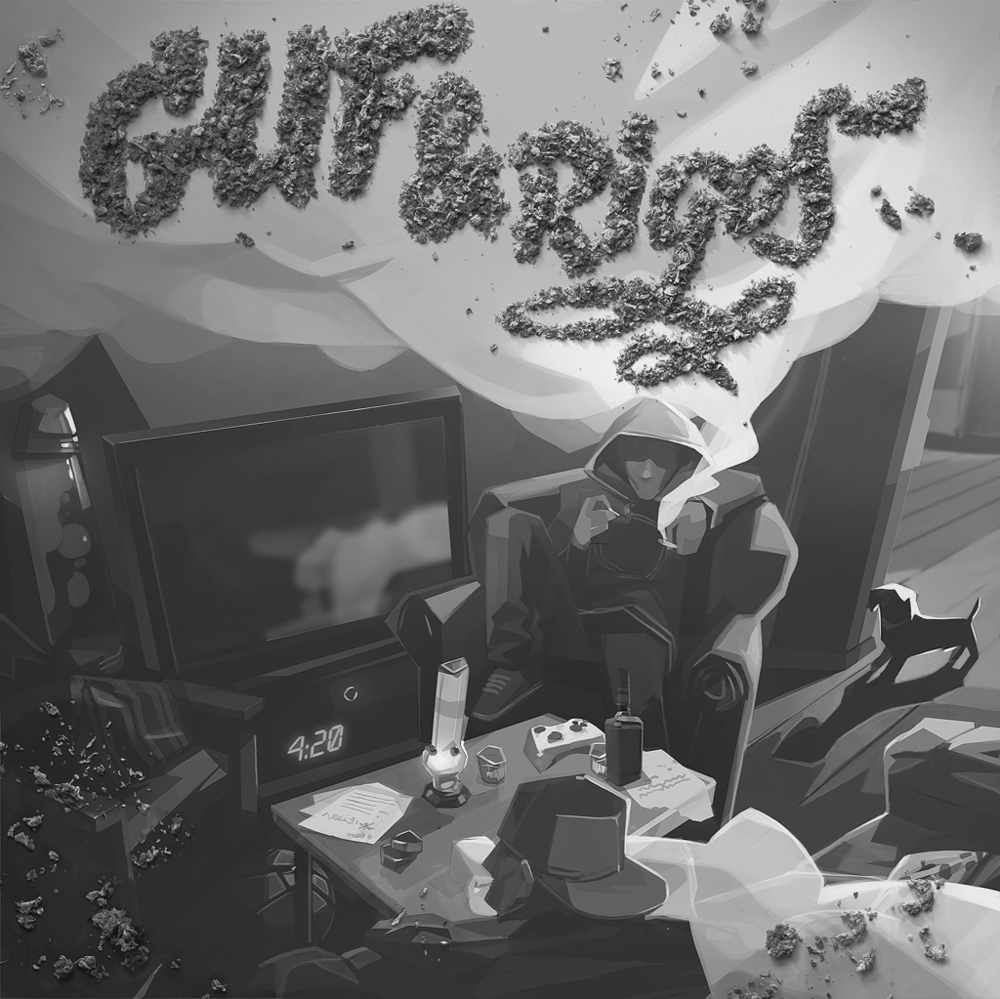

In [5]:
cv2_imshow(image)

# Выполняем функцию на CPU и засекаем время работы

In [6]:
start_cpu = time.time()
output = BilateralCPU(image, sigma_r, sigma_d)
end_cpu = time.time() - start_cpu
cv2.imwrite('/bilateral_images/result_cpu.bmp', output)

True

# Смотрим результат работы на CPU

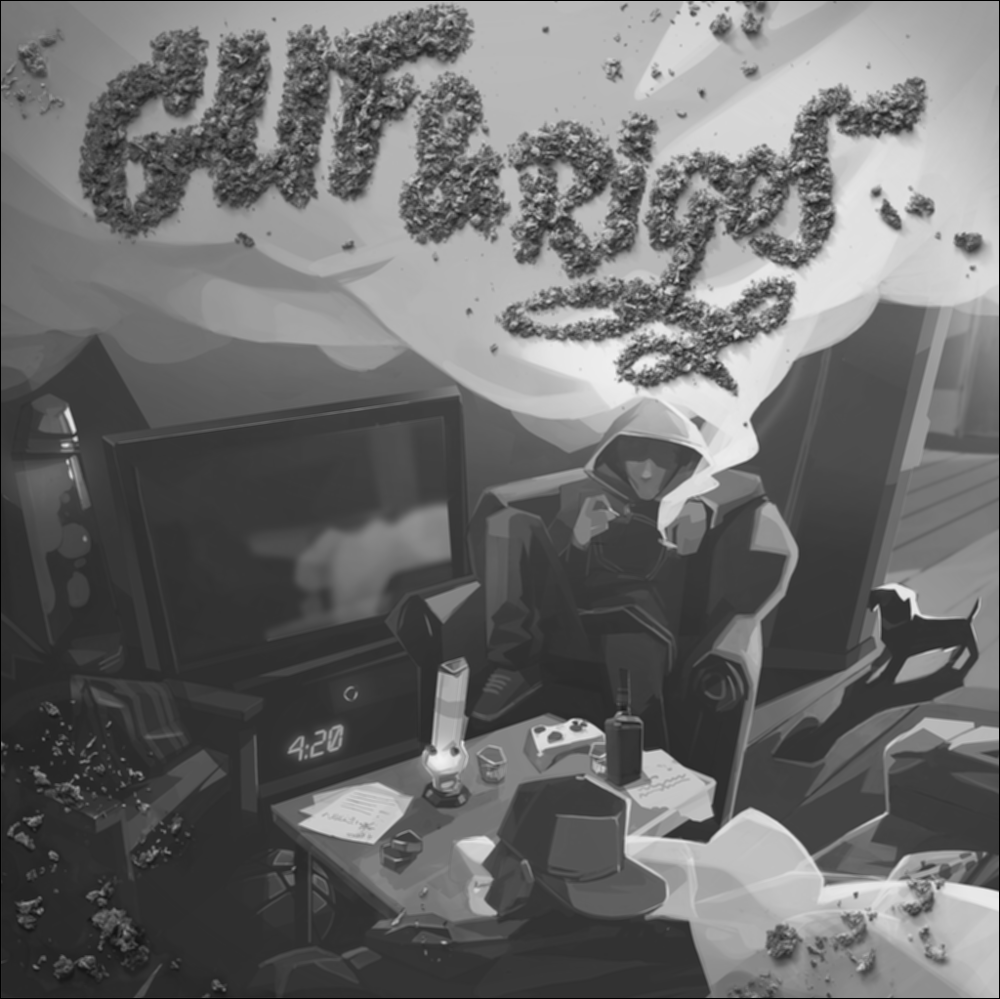

In [7]:
cv2_imshow(output)

# Запускаем функцию на GPU

In [8]:
output_gpu = np.zeros((image.shape[0], image.shape[1]), dtype = np.uint32) 
block_size = (8,8,1)
grid_size = (int(np.ceil(image.shape[0]/block_size[0])),int(np.ceil(image.shape[1]/block_size[1])))
BilateralFilteringGPU = BilateralGPU.get_function("BilateralGPU")

start_gpu = time.time()
tex = BilateralGPU.get_texref("tex")
tex.set_filter_mode(pycuda.driver.filter_mode.LINEAR)
tex.set_address_mode(0, pycuda.driver.address_mode.MIRROR)
tex.set_address_mode(1, pycuda.driver.address_mode.MIRROR)
pycuda.driver.matrix_to_texref(image.astype(np.uint32), tex, order="C")

BilateralFilteringGPU(
    pycuda.driver.Out(output_gpu), 
    np.int32(image.shape[0]), 
    np.int32(image.shape[1]), 
    np.float32(sigma_r), 
    np.float32(sigma_d), 
    block=block_size, 
    grid=(int(np.ceil(image.shape[0]/block_size[0])),int(np.ceil(image.shape[1]/block_size[1]))), 
    texrefs=[tex]
)

pycuda.driver.Context.synchronize()
end_gpu = time.time() - start_gpu

cv2.imwrite('/bilateral_images/result_gpu.bmp', output_gpu.astype(np.uint8))

True

# Смотрим результат на GPU

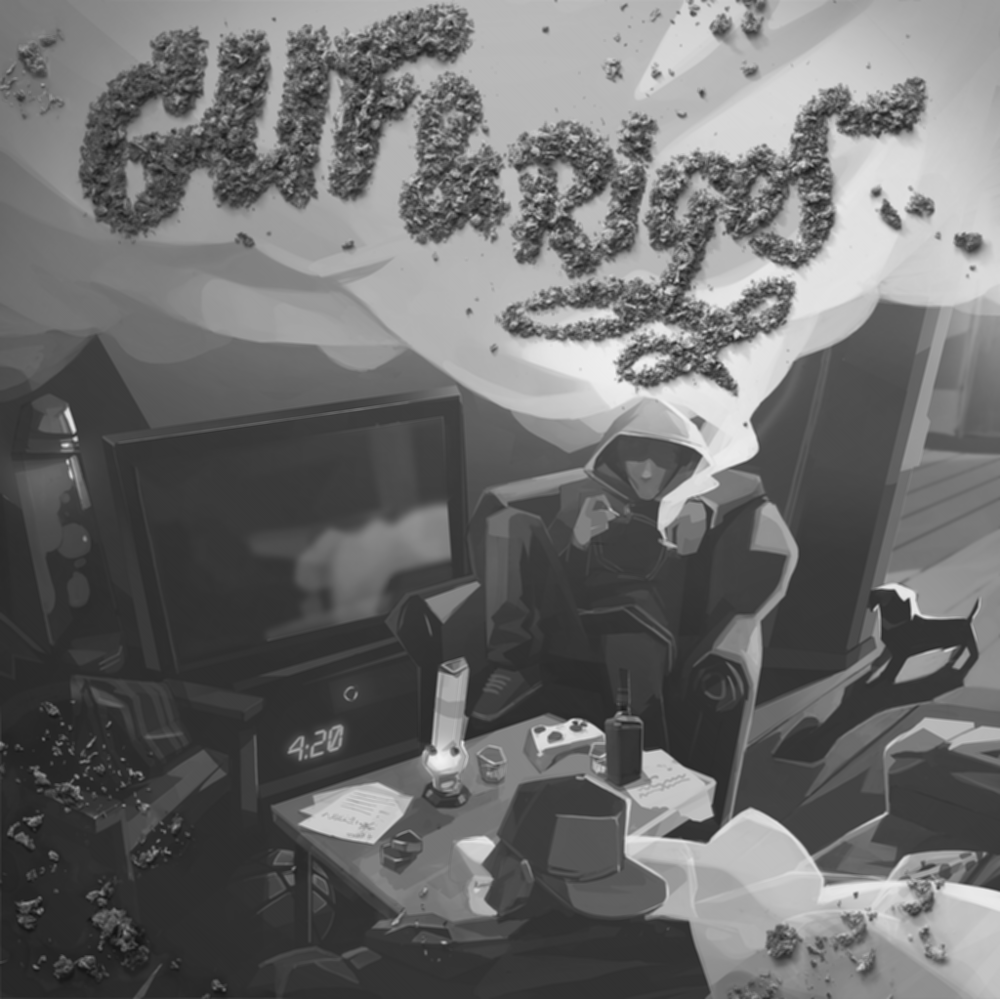

In [9]:
cv2_imshow(output_gpu)

In [10]:
df = pd.DataFrame(columns=["Время на GPU", "Время на CPU", "CPU/GPU"])
df = df.append({"Время на GPU": end_gpu, "Время на CPU": end_cpu, "CPU/GPU": end_cpu/end_gpu}, ignore_index=True)

In [11]:
df

,Время на GPU,Время на CPU,CPU/GPU
0,0.013125,81.839198,6235.168114
